In [1]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF

In [2]:
# Use this if you are using any Cuda enabled system
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        label_path = os.path.join(self.label_dir, self.images[index].replace('.png', '_L.png'))
        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path)
        label = self.convert_to_one_hot_label(label)
        if self.transform is not None:
            image = self.transform(image)
            label = torch.tensor(label, dtype=torch.float32).permute(2, 0, 1)  # Convert labels to tensor
        return image, label
    
    def convert_to_one_hot_label(self, label):
        # Convert PIL Image to a NumPy array
        np_label = np.array(label)
        # Initialize a one-hot label array with two channels
        one_hot_label = np.zeros((np_label.shape[0], np_label.shape[1], 2), dtype=np.uint8)
        # All non-pedestrian pixels are marked in the 'other' channel (channel 0)
        one_hot_label[:, :, 0] = 1  # Initially set all to 'other'
        # Set pedestrian pixels in the pedestrian channel (channel 1)
        pedestrian_mask = (np_label[:, :, 0] == 128) & (np_label[:, :, 1] == 0) & (np_label[:, :, 2] == 0)
        one_hot_label[pedestrian_mask, 0] = 0  # Remove 'other' tag for pedestrians
        one_hot_label[pedestrian_mask, 1] = 1  # Set 'pedestrian' tag
        # Convert back to a PIL Image for each channel if needed (or handle as tensor in PyTorch)
        return one_hot_label

In [4]:
# Define transforms if necessary
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Assuming you have your dataset in 'CamVid/images' and 'CamVid/labels'
image_dir = 'CamVid/train'
label_dir = 'CamVid/train_labels'

dataset = CamVidDataset(image_dir, label_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

torch.Size([4, 3, 720, 960])
torch.Size([4, 2, 720, 960])


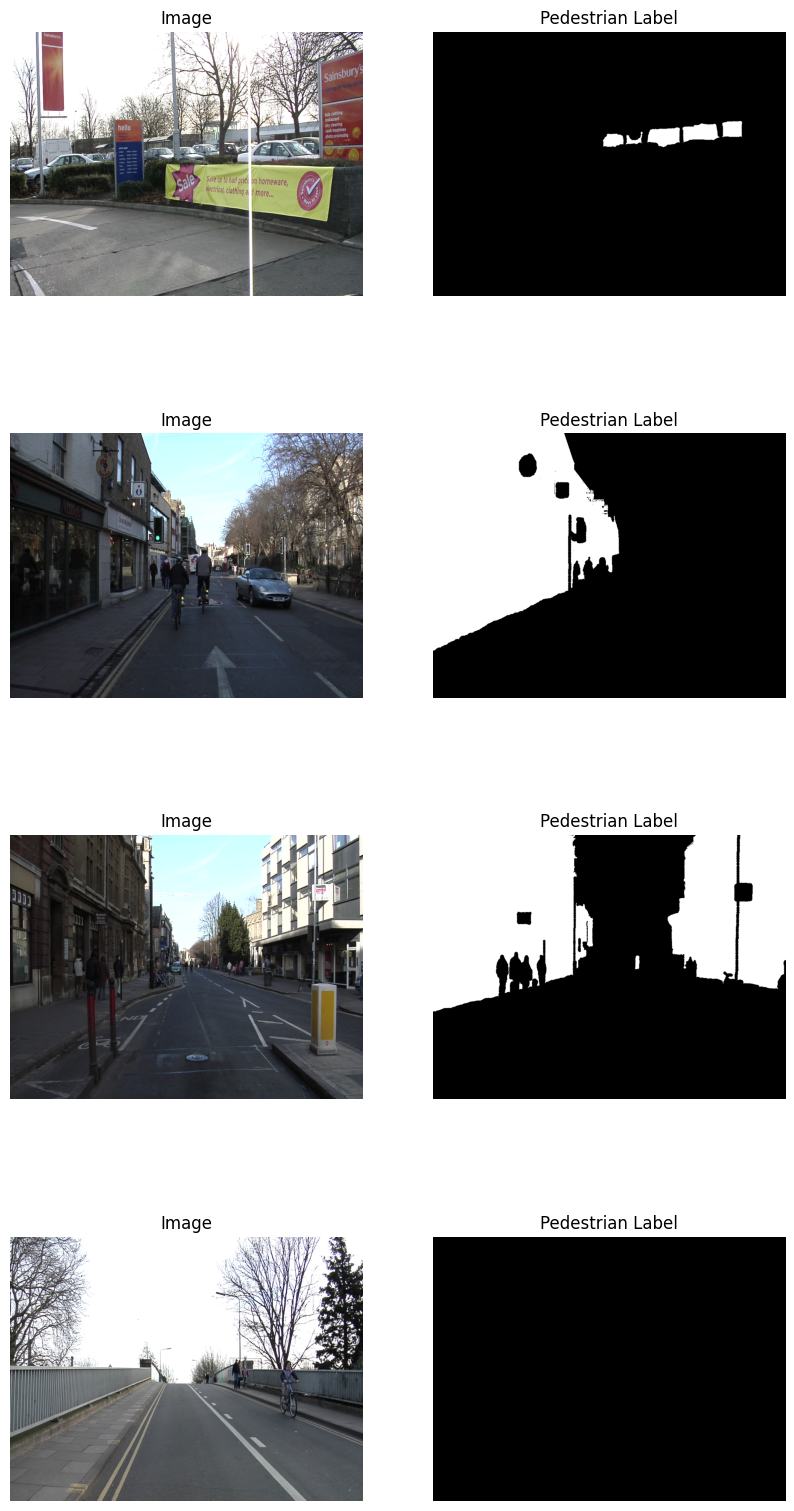

In [5]:
batch_size = 4

def visualize_one_hot_labels(batch_images, batch_labels):
    # This function assumes batch_labels is a batch of one-hot encoded labels
    fig, axs = plt.subplots(batch_size, 2, figsize=(10, batch_size * 5))
    for i in range(batch_size):
        img = batch_images[i].permute(1, 2, 0)  # Convert CxHxW to HxWxC for matplotlib
        lbl = batch_labels[i].permute(1, 2, 0).numpy()
        pedestrian = lbl[:, :, 1]  # Extract the pedestrian channel

        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(pedestrian, cmap='gray')
        axs[i, 1].set_title('Pedestrian Label')
        axs[i, 1].axis('off')

    plt.show()


# Get one batch of data
images, labels = next(iter(dataloader))
print(images.shape)
print(labels.shape)
visualize_one_hot_labels(images, labels)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(
    #    self, in_channel=3, out_channel=3, features=[64, 128, 256, 512],
       self, in_channel=3, out_channel=1, features=[32, 64, 128, 256],
    ): 
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling
        for feature in features:
            self.downs.append(DoubleConv(in_channel, feature))
            in_channel = feature
        
        # Upsampling
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channel, 1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x =self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [7]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class Autoencoder(nn.Module):
    def __init__(self, latent_dim,hidden_dim,input_dim):
        super(Autoencoder, self).__init__()
        output_dim = input_dim
        #TODO
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim,latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
            Reshape(-1, 1, 720, 960)
        )

    def forward(self, x):
        #TODO
        x = self.encoder(x)
        x = self.decoder(x)
        # x = x.view(-1, 1, 28, 28)

        return x

In [8]:
class DenoiseAE(nn.Module):
    def __init__(self):
        super(DenoiseAE, self).__init__()
        #TODO
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8,kernel_size=3,padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=8, out_channels=16,kernel_size=4,padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=16, out_channels=32,kernel_size=8,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16,kernel_size=2,stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=16, out_channels=8,kernel_size=6,stride=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=8, out_channels=2,kernel_size=2,stride=1),
            nn.BatchNorm2d(2),
            nn.LeakyReLU(0.2),

            nn.Sigmoid(),
            Reshape(-1, 2, 720, 960)
        )
    
    def forward(self,x):
        #TODO
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
model = UNet(in_channel=3, out_channel=2).to(device)

# hidden_dim = 64
# latent_dim = 2
# batch_size = 64
# model = Autoencoder(latent_dim, hidden_dim, 3*720*960).to(device)
# model = DenoiseAE().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    i = 0
    for inputs, labels in dataloader:
        i += 1
        if i > 10:
            break
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # print(labels.shape)
        # print(outputs.shape)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def plot_example(dataset, model, device, index=0):
    # Ensure the model is in eval mode
    model.eval()
    
    # Get an example from the dataset
    original_image, label = dataset[index]
    original_image = original_image.unsqueeze(0)  # Add batch dimension if needed
    
    # Move image to the device where the model is
    original_image = original_image.to(device)
    
    with torch.no_grad():  # Inference without tracking gradients
        prediction = model(original_image)
    
    # Assuming the prediction and label are class indices, you might need to convert them to color maps.
    # This step depends on your specific implementation and how your data is formatted.
    
    # Convert images to numpy for plotting (adjust as necessary)
    original_image_np = original_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    prediction_np = prediction.squeeze(0).cpu().numpy()  # Adjust based on your prediction format
    label_np = label.cpu().numpy()  # Adjust based on your label format
    
    
    prediction_np = prediction_np.transpose(1, 2, 0)
    prediction_np = np.argmax(prediction_np, axis=2)
    label_np = label_np.transpose(1, 2, 0)
    label_np = np.argmax(label_np, axis=2)
    print(original_image_np.shape)
    print(prediction_np.shape)
    print(label_np.shape)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(prediction_np)
    axes[1].set_title('Model Prediction')
    axes[1].axis('off')
    
    axes[2].imshow(label_np)
    axes[2].set_title('Label Image')
    axes[2].axis('off')
    
    plt.show()

# Example usage:
# Assuming `dataset` is an instance of `CamVidDataset` and `model` is your trained model.
# plot_example(dataset, model, device='cuda', index=0)
plot_example(dataset, model, device, 0)
